# Image Segmentation with tf.keras - 변형


### 설정

In [1]:
!pip install kaggle
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  


In [0]:
import tf_utils

### 파일 다운/설정

In [0]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()


In [0]:
import kaggle

In [0]:
competition_name = 'carvana-image-masking-challenge'

def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')
    

In [0]:
get_data(competition_name)
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)    
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
    

### 파라미터 세팅

In [0]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 5

### 데이터 세팅

In [0]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_jpeg(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  # These are gif images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_gif(label_img_str)[0]
  # The label image should only have values of 1 or 0, indicating pixel wise
  # object (car) or not (background). We take the first channel only. 
  print("label_img shape : " ,tf.shape(label_img))
  label_img = label_img[:, :, 0]
  print("label_img shape : " ,tf.shape(label_img))
  label_img = tf.expand_dims(label_img, axis=-1)
  print("label_img shape : " ,tf.shape(label_img))
  return img, label_img

def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
  
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.to_float(label_img) * scale
  img = tf.to_float(img) * scale 
  return img, label_img

def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset



In [8]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)


label_img shape :  Tensor("Shape:0", shape=(3,), dtype=int32)
label_img shape :  Tensor("Shape_1:0", shape=(2,), dtype=int32)
label_img shape :  Tensor("Shape_2:0", shape=(3,), dtype=int32)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
label_img shape :  Tensor("Shape:0", shape=(3,), dtype=int32)
label_img shape :  Tensor("Shape_1:0", shape=(2,), dtype=int32)
label_img shape :  Tensor("Shape_2:0", shape=(3,), dtype=int32)


### 모델 생성

In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [0]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [0]:
model = models.Model(inputs=[inputs], outputs=[outputs])

### 성능평가랑 loss 함수 설정/ 모델 돌리기

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

In [0]:
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [25]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1356/1357 [============================>.] - ETA: 0s - loss: 0.3875 - dice_loss: 0.0716
Epoch 00001: val_dice_loss improved from inf to 0.02082, saving model to /tmp/weights.hdf5
1357/1357 [==============================] - 468s 345ms/step - loss: 0.3873 - dice_loss: 0.0716 - val_loss: 0.1179 - val_dice_loss: 0.0208
Epoch 2/5
1356/1357 [============================>.] - ETA: 0s - loss: 0.1026 - dice_loss: 0.0173
Epoch 00002: val_dice_loss improved from 0.02082 to 0.02002, saving model to /tmp/weights.hdf5
1357/1357 [==============================] - 310s 229ms/step - loss: 0.1025 - dice_loss: 0.0173 - val_loss: 0.1395 - val_dice_loss: 0.0200
Epoch 3/5
1356/1357 [============================>.] - ETA: 0s - loss: 0.0910 - dice_loss: 0.0150
Epoch 00003: val_dice_loss improved from 0.02002 to 0.01243, saving model to /tmp/weights.hdf5
1357/1357 [==============================] - 308s 227ms/step - loss: 0.0910 - dice_loss: 0.0150 - v

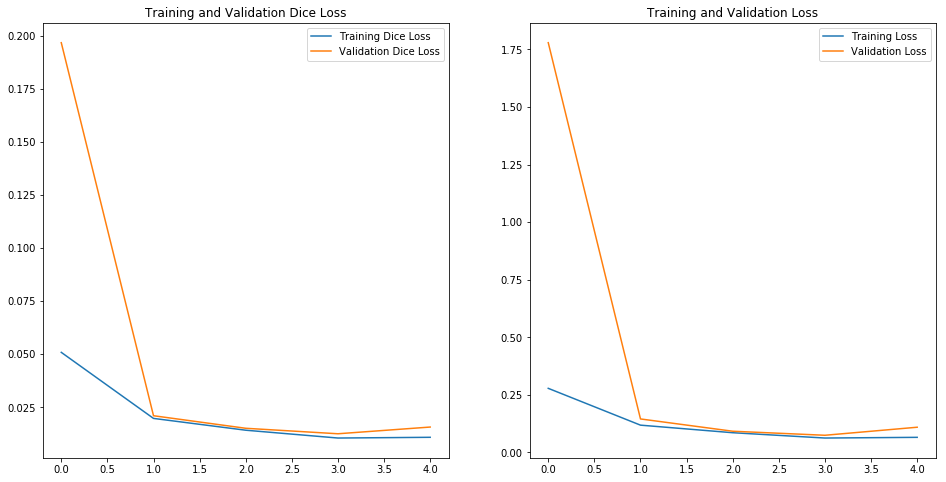

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [0]:
load_data_from_zip(competition_name, 'test.zip')


In [0]:
test_dir = os.path.join(competition_name, "test")

In [0]:
test_filenames = []
test_filenames = glob.glob("carvana-image-masking-challenge/test/*.jpg")

num_test = len(test_filenames)

In [0]:
# 램딸려서 계속팅김 ㅠㅠ

test_filenames = test_filenames[:1000]
num_test = len(test_filenames)

In [13]:
test_filenames[:10]

['carvana-image-masking-challenge/test/f94186f3ae28_10.jpg',
 'carvana-image-masking-challenge/test/70bf1a9b7f69_10.jpg',
 'carvana-image-masking-challenge/test/af7fe7b587b2_15.jpg',
 'carvana-image-masking-challenge/test/a8927c582d16_02.jpg',
 'carvana-image-masking-challenge/test/edb913a8b76b_04.jpg',
 'carvana-image-masking-challenge/test/a0954a5ddb1b_07.jpg',
 'carvana-image-masking-challenge/test/956fca2de327_16.jpg',
 'carvana-image-masking-challenge/test/c64396247bda_11.jpg',
 'carvana-image-masking-challenge/test/09ac3951fe5b_07.jpg',
 'carvana-image-masking-challenge/test/abbe25efa64f_07.jpg']

In [14]:
test_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
test_preprocessing_fn = functools.partial(_augment, **test_cfg)

test_ds = get_baseline_dataset(test_filenames,
                                test_filenames, #레이블 없으니까 상관없을거같고 넣을거 없어서 걍 test 두번 넣음
                                preproc_fn=test_preprocessing_fn,
                                batch_size=batch_size )


label_img shape :  Tensor("Shape:0", shape=(3,), dtype=int32)
label_img shape :  Tensor("Shape_1:0", shape=(2,), dtype=int32)
label_img shape :  Tensor("Shape_2:0", shape=(3,), dtype=int32)


In [15]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

Instructions for updating:
Use tf.cast instead.


In [16]:
# Let's visualize some of the outputs 
data_aug_iter = test_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

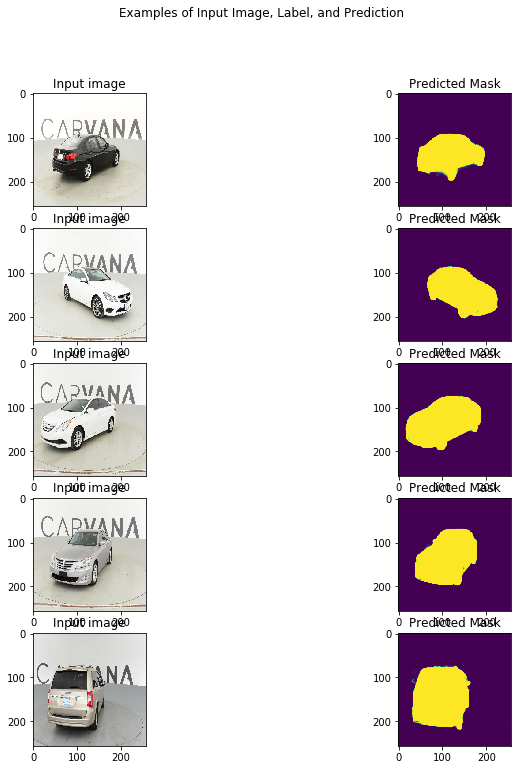

In [17]:
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0] 
  
  plt.subplot(5, 2, 2 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 2, 2 * i + 2)
  plt.imshow(predicted_label[0:, :, 0])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()